<b>Arnie Larson<br>
EEP 592 - Radar, Autumn 2022<br>
HW4<br>
10/25/2022</b>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy import signal
from scipy.io import wavfile


<b>1)</b><br>

A C Band radar (5.5GHz) employs a Linear Chirp FM pulse compressed radar with a 1.0ms uncompressed pulse width, having a down chirp covering a bandwidth of 200 MHz.

If the target has a radial velocity of 2 km/s, what is the range error in terms of the resolution of the compressed pulse.

Express the range error due to Doppler as a multiple of the native range resolution (no Doppler)

With no doppler accounted for, the resolution of the higher bandwidth LFM pulse is much better than a rectangular pulse of single frequency and 1.0ms duration.

<b>A:</b>   $\Delta d \approx \frac{c}{B} \approx 0.75 m$

From Richards Ch. 4 - the ambiguity function for the LFM pulse shows that range resolution is in the presence of doppler will shift the measured t.  Using equation 4.106 this provides an estimate of the decreased range resolution due to doppler effects.

<b>A:</b>   $\delta R \approx 55m \approx 73 \Delta d$

In [2]:
# normal range formula, 
c=3e8; f=5.5e9; tau=1e-3; B = 200e6; dx=c/(2*B)
fD=2*(2e3/c)*f
dR=c*tau*fD/(2*B)
print("Non doppler range: {:.3f}".format(dx))
print("Doppler for v = 15.km/s, FD: {:f}".format(fD))
print("Doppler adjusted range error: {}".format(dR))

Non doppler range: 0.750
Doppler for v = 15.km/s, FD: 73333.333333
Doppler adjusted range error: 55.0


<b>2)</b><br>

Simulation with MTI, multiple target interference effects.

- What would the effect of multiple consistent frequency interferences be on the spectrogram?

- How could you use MTI ideas to filter these types of clutter from a spectrogram?

<b>a)</b>

Generate signals with constant frequency.  First, generate the bicycle and car signals (with non diminishing amplitude/RCS).  Second, add in signals with 500Hz (-90dBFS); 1500Hz (-80dBFS); 2500Hz (-70dBFS)

<b>b)</b> 

Next attempt to process the spectrogram by subtracting the moving average of *w* most recent frequency bins.  For the first few time slices there will be less information to remove.  Plot the processed spectrogram for w=1, w=10 and w=100

I produce plots below with removal of averages for window size = 1, 2, 10 and 100
For window size = 1, my algorithm initially was just removing the signal, as probably I have an off by one error per the expectation.  I corrected this by adding a columbn of zeros to the front of my averaged S.  When I remove the previous frequency bin average energy the clutter const frequencies are strongly suppressed.  Since I'm doing a time average of about 1000 points, I only have about 133 time slices, so doing an average of the previous 100 isn't as effective.

In [3]:
import alarso_doppler as dop

In [4]:
seconds=15; fs=8000;
t=np.linspace(0,seconds,num=fs*seconds)
S_c=dop._generate_motion_signal(t, cs=50, x0=1, v0=28.6, a0=0.5, ircs=True)
S_b=dop._generate_motion_signal(t, cs=2, x0=1, v0=4.5, a0=0.1, ircs=True)
FS=S_c.max(); print("Full scale: {:.3f}".format(FS))
print("Bicycle fulls scale: {:.3f}".format(S_b.max()))
# generate three tones, choosing to use ~ int16 FS to make noisy plot..
FS=32000
a1=FS*20**(-90/20); print("Tone 1 scale a1: {:.6f}".format(a1))
S1=dop._generate_freq_signal(t, a1, 500)
a2=FS*20**(-80/20); print("Tone 2 scale a2: {:.6f}".format(a2))
S2=dop._generate_freq_signal(t, a2, 1500)
a3=FS*20**(-70/20); print("Tone 3 scale a3: {:.6f}".format(a3))
S3=dop._generate_freq_signal(t, a3, 2500)
St=S1+S2+S3

Full scale: 7.071
Bicycle fulls scale: 1.414
Tone 1 scale a1: 0.044721
Tone 2 scale a2: 0.200000
Tone 3 scale a3: 0.894427


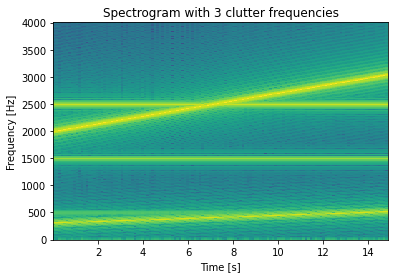

In [5]:
f, t, S = signal.spectrogram(S_c+S_b+St, fs, nperseg=1024) #, nfft=256*2)
dop._plot_spectrogram(f, t, S, title="Spectrogram with 3 clutter frequencies")

### The Algorithm outline for this MTI 

- Idea for MTI - remove an average of the energy over several, N recent bins
- S.shape (513, 133) => 513 rows (frequency bins) and 133 columns (time bins)
- f.shape (513, )  => 513 frequency values (ft done on 1024 time slices, 8 times a second)
- for each row (frequency bin), compute the rolling average
- Process Spectrogram and remove this average
- Implementation for attemping to keep track of an average by using convolution, idea from:
https://stackoverflow.com/questions/14313510/how-to-calculate-rolling-moving-average-using-python-numpy-scipy

In [6]:
# Basic Idea - generate a window
window = np.ones(10)
window /= window.size
window

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

(142,)


Text(0.5, 1.0, 'Average of 10 previous points in a given frequency bin')

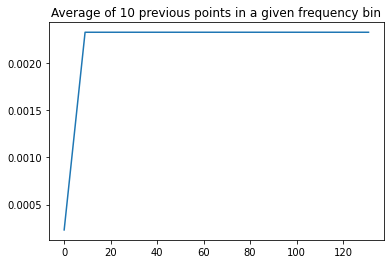

In [7]:
# Convolve with constant window and drop the last N-1 elements
ave=np.convolve(window, S[192,])
print(ave.shape)
plt.plot(ave[:132])
plt.title("Average of 10 previous points in a given frequency bin")


In [38]:
# Function to generate frequency bin averages
# for each frequency bin, generate desired running average 
# set mininum value of transformed spec to 1e-21
def get_freq_binned_spec(f, S, w=10):
    Sa=None
    window = np.ones(w)/w
    for i in range(f.size):
        Sfa = np.convolve(window, S[i,])
        if Sa is None:
            Sa=Sfa
        else:
            Sa=np.vstack((Sa,Sfa))
    # Add a columnb of zeros at the beginning 
    Sa = np.hstack((np.zeros((Sa.shape[0],1)), Sa))
    return Sa
    

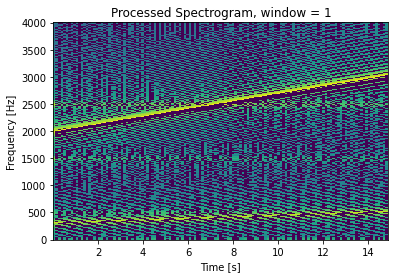

In [44]:
# Plot of spectrogam processed with window of 1
A1 = get_freq_binned_spec(f, S, 1)
Sp1 = S-A1[:,:133]
dop._plot_spectrogram(f, t, Sp1.clip(min=1e-21), title="Processed Spectrogram, window = 1")

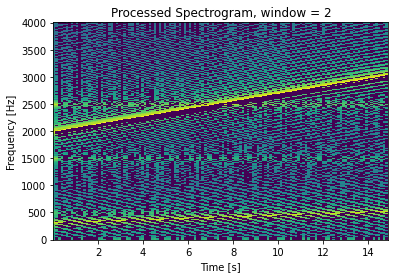

In [45]:
# Plot of spectrogam processed with window of 2
A1 = get_freq_binned_spec(f, S, 2)
Sp1 = S-A1[:,:133]
dop._plot_spectrogram(f, t, Sp1.clip(min=1e-21), title="Processed Spectrogram, window = 2")

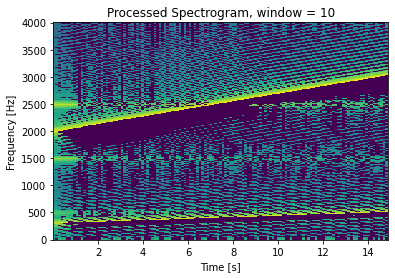

In [46]:
# Plot of spectrogam processed with window of 10
A1 = get_freq_binned_spec(f, S, 10)
Sp1 = S-A1[:,:133]
dop._plot_spectrogram(f, t, Sp1.clip(min=1e-21), title="Processed Spectrogram, window = 10")

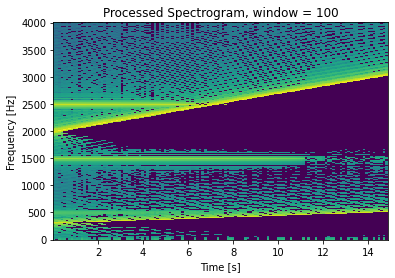

In [47]:
# Plot of spectrogam processed with window of 100
A1 = get_freq_binned_spec(f, S, 100)
Sp1 = S-A1[:,:133]
dop._plot_spectrogram(f, t, Sp1.clip(min=1e-21), title="Processed Spectrogram, window = 100")